# Quick usage of CovserPhy

## Preparation

In [1]:
import os
os.chdir("../")

In [2]:
import covsirphy as cs
cs.__version__

'2.4.2'

## Dataset preparation

In [3]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

### The number of cases (JHU style)

In [4]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [5]:
print(data_loader.covid19dh_citation)

Australian Bureau of Statistics (2019), https://www.abs.gov.au/
CIA - Central Intelligence Agency (2018), https://www.cia.gov/
CIA - Central Intelligence Agency (2019), https://www.cia.gov/
CIA - Central Intelligence Agency (2020), https://www.cia.gov/
COVID-19 Turkey API (2020), https://github.com/
COVID-19_plus_Russia GitHub repository (2020), https://github.com/
COVID19-India API (2020), https://www.covid19india.org/
Canada's National Statistical Agency (2020), https://www150.statcan.gc.ca/
Centre of Excellence in Economics and Data Science, University of Milano (2020), https://github.com/
Covid19data.com.au (2020), https://github.com/
Czech Statistical Office (2018), https://www.czso.cz/
Data Science for Social Impact research group, University of Pretoria (2020), https://github.com/
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be/
Eurostat (2019), https://ec.europa.eu/
Geloky (2019), https://geloky.com/
Istituto Nazionale di Statistica, Italia (2018), htt

In [6]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
141831,2020-07-07,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141832,2020-07-08,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141833,2020-07-09,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141834,2020-07-10,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141835,2020-07-11,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [7]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
141831,2020-07-07,Colombia,Vichada,1,0,0,1
141832,2020-07-08,Colombia,Vichada,1,0,0,1
141833,2020-07-09,Colombia,Vichada,1,0,0,1
141834,2020-07-10,Colombia,Vichada,1,0,0,1
141835,2020-07-11,Colombia,Vichada,1,0,0,1


In [8]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
174,2020-07-07,6973,942,325,5706
175,2020-07-08,7048,951,325,5772
176,2020-07-09,7272,1071,325,5876
177,2020-07-10,7515,1314,325,5876
178,2020-07-11,7515,1314,325,5876


In [9]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-07-07,17716654,8642711,800078,8273865,0.045160,0.467011,0.088173
2020-07-08,18032501,8754144,806972,8471385,0.044751,0.469784,0.086974
2020-07-09,18364770,8906387,813775,8644608,0.044312,0.470717,0.086037
2020-07-10,18529577,9019301,816021,8694255,0.044039,0.469210,0.085804
2020-07-11,18529583,9019307,816021,8694255,0.044039,0.469209,0.085804


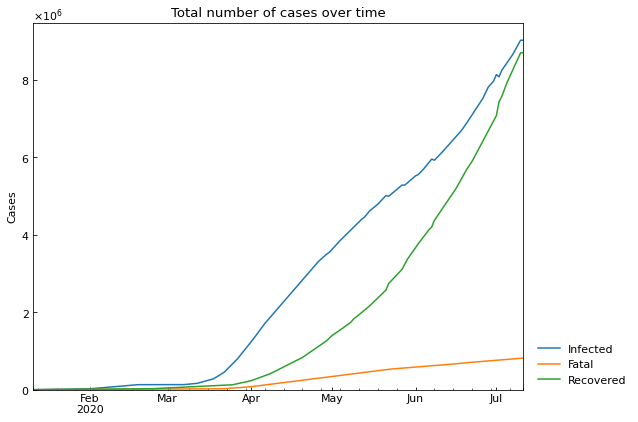

In [10]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [11]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
176,2020-07-05,19767,1766,976,17025
177,2020-07-06,19943,1866,977,17100
178,2020-07-07,20151,1982,979,17190
179,2020-07-08,20358,2052,981,17325
180,2020-07-09,20713,2271,981,17461


In [12]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan


In [13]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
146,2020-07-06,19775,1674,977,17124
147,2020-07-07,19981,1806,978,17197
148,2020-07-08,20074,1763,980,17331
149,2020-07-09,20371,1924,981,17466
150,2020-07-10,20719,2085,982,17652


### Population in each country

In [14]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [15]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
141831,2020-07-07,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141832,2020-07-08,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141833,2020-07-09,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141834,2020-07-10,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141835,2020-07-11,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [16]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Population
783,CZE,Czech Republic,Plzenský kraj,584672
784,COL,Colombia,Bolívar,2070110
785,RUS,Russia,Murmansk oblast,795409
786,RUS,Russia,Republic of Crimea,1913731
787,COL,Colombia,Vichada,107808


In [17]:
population_data.value("Japan", province=None)

126529100

In [18]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [19]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Working paper, doi: 10.13140/RG.2.2.11649.81763.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation


In [20]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
141831,2020-07-07,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141832,2020-07-08,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141833,2020-07-09,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141834,2020-07-10,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04
141835,2020-07-11,1,1,0,107808.0,COL,Vichada,Colombia,3,2,2,4,1,2,2,4,2,2,2,87.04


In [21]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
141831,2020-07-07,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
141832,2020-07-08,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
141833,2020-07-09,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
141834,2020-07-10,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04
141835,2020-07-11,Colombia,COL,3,2,2,4,1,2,2,4,2,2,2,87.04


In [22]:
# Subset for a country
oxcgrt_data.subset(country="Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
178,2020-07-07,2,0,1,0,0,0,0,3,2,2,1,27.78
179,2020-07-08,2,0,1,0,0,0,0,3,2,2,1,27.78
180,2020-07-09,2,0,1,0,0,0,0,3,2,2,1,27.78
181,2020-07-10,2,0,1,0,0,0,0,3,2,2,1,27.78
182,2020-07-11,2,0,1,0,0,0,0,3,2,2,1,27.78


In [23]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset(iso3="JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
178,2020-07-07,2,0,1,0,0,0,0,3,2,2,1,27.78
179,2020-07-08,2,0,1,0,0,0,0,3,2,2,1,27.78
180,2020-07-09,2,0,1,0,0,0,0,3,2,2,1,27.78
181,2020-07-10,2,0,1,0,0,0,0,3,2,2,1,27.78
182,2020-07-11,2,0,1,0,0,0,0,3,2,2,1,27.78


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [24]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

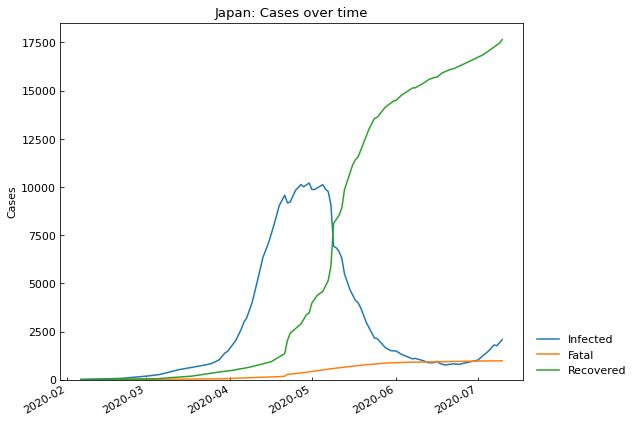

,Date,Confirmed,Infected,Fatal,Recovered
146,2020-07-06,19775,1674,977,17124
147,2020-07-07,19981,1806,978,17197
148,2020-07-08,20074,1763,980,17331
149,2020-07-09,20371,1924,981,17466
150,2020-07-10,20719,2085,982,17652


In [25]:
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

In [ ]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<Main scenario: perform parameter estimation>
Running optimization with 8 CPUs...
	11th phase with SIR-F model finished 307 trials in 0 min 40 sec.
	2nd phase with SIR-F model finished 118 trials in 0 min 25 sec.
	3rd phase with SIR-F model finished 135 trials in 0 min 35 sec.
	1st phase with SIR-F model finished 267 trials in 1 min 2 sec.
	4th phase with SIR-F model finished 170 trials in 0 min 57 sec.
	6th phase with SIR-F model finished 72 trials in 0 min 26 sec.
	5th phase with SIR-F model finished 168 trials in 1 min 2 sec.
	8th phase with SIR-F model finished 24 trials in 0 min 10 sec.
	7th phase with SIR-F model finished 108 trials in 0 min 36 sec.
	9th phase with SIR-F model finished 58 trials in 0 min 21 sec.
	10th phase with SIR-F model finished 160 trials in 0 min 36 sec.
Completed optimization. Total: 3 min 50 sec


In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,rho,sigma,theta,kappa,tau,Rt,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day],RMSLE,Trials,Runtime
1st,Past,06Apr2020,19Apr2020,126529100,SIR-F,0.023543,0.002114,0.001566,0.000558,360,8.79,0.002,447,10,118,0.230430,267,1 min 2 sec
2nd,Past,20Apr2020,23Apr2020,126529100,SIR-F,0.010632,0.012520,0.013200,0.000400,360,0.81,0.013,624,23,19,0.093550,118,0 min 25 sec
3rd,Past,24Apr2020,27Apr2020,126529100,SIR-F,0.009252,0.003320,0.013109,0.000054,360,2.71,0.013,4601,27,75,0.015499,135,0 min 35 sec
4th,Past,28Apr2020,02May2020,126529100,SIR-F,0.006169,0.006537,0.090838,0.000180,360,0.84,0.091,1388,40,38,0.031318,170,0 min 57 sec
5th,Past,03May2020,09May2020,126529100,SIR-F,0.003739,0.012968,0.414062,0.000150,360,0.17,0.414,1671,66,19,0.173653,168,1 min 2 sec
6th,Past,10May2020,15May2020,126529100,SIR-F,0.005218,0.021818,0.216201,0.000768,360,0.18,0.216,325,47,11,0.062930,72,0 min 26 sec
7th,Past,16May2020,28May2020,126529100,SIR-F,0.003137,0.023050,0.469776,0.000450,360,0.07,0.470,555,79,10,0.090957,108,0 min 36 sec
8th,Past,29May2020,10Jun2020,126529100,SIR-F,0.008962,0.014992,0.157772,0.001978,360,0.44,0.158,126,27,16,0.081916,24,0 min 10 sec
9th,Past,11Jun2020,21Jun2020,126529100,SIR-F,0.020266,0.023837,0.003631,0.002420,360,0.77,0.004,103,12,10,0.046150,58,0 min 21 sec
10th,Past,22Jun2020,02Jul2020,126529100,SIR-F,0.027592,0.017840,0.115478,0.000546,360,1.33,0.115,458,9,14,0.062862,160,0 min 36 sec


### Accuracy of estimation

In [ ]:
scenario.estimate_accuracy(phase="10th")

### Get parameter value

In [ ]:
scenario.get("Rt", phase="4th")

### Show parameter history

In [ ]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

### Show the history of reproduction number

In [ ]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

### Simulate the number of cases

In [ ]:
scenario.clear(name="Main")
scenario.add_phase(name="Main", end_date="01Jan2021")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [ ]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

In [ ]:
sigma_new = sigma_current * 2
sigma_new

In [ ]:
scenario.clear(name="Medicine")
scenario.add_phase(name="Medicine", days=30, sigma=sigma_current)
scenario.add_phase(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

In [ ]:
scenario.simulate(name="Medicine").tail()

## Compare the scenarios

In [ ]:
scenario.describe()